In [92]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
import numpy as np
from collections import defaultdict
import unicodedata
from rapidfuzz import process
from rapidfuzz.fuzz import token_sort_ratio
from scipy.stats import wasserstein_distance
from itertools import combinations
from scipy.sparse import csr_matrix

In [93]:
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Important DataFrames\NBA_draft_combine.csv").drop(columns = ['BF', 'BMI', 'HANDL', 'HANDW', 'BAR', 'PAN', 'PBHGT', 'PDHGT'])

In [94]:
df

,YEAR,PLAYER,POS,HGT,WGT,WNGSPN,STNDRCH,STNDVERT,LPVERT,LANE,SHUTTLE,SPRINT,BENCH
0,2024,"Ajayi, Michael",SF,77.80,227.8,84.80,106.5,27.0,34.5,12.00,3.17,3.21,NaN
1,2024,"Ajinca, Melvin",SF,79.30,213.8,79.50,106.5,26.5,31.0,12.00,3.00,3.38,NaN
2,2024,"Alexander, Trey",SG,75.30,187.0,82.50,101.5,27.0,32.0,11.00,3.00,3.00,NaN
3,2024,"Almansa, Izan",C,81.30,219.6,85.00,110.0,28.0,35.0,11.00,3.00,3.00,NaN
4,2024,"Beekman, Reece",PG,73.30,196.4,78.50,100.0,30.0,37.0,11.00,3.00,3.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,2000,"Smith, Mike",SF,78.50,198.0,80.50,103.0,33.0,21.0,11.32,NaN,3.22,12.0
1606,2000,"Stephens, Jarrett",PF,77.25,258.0,81.25,103.0,27.0,29.0,11.98,NaN,3.46,13.0
1607,2000,"Thornton, Bootsy",SG,75.50,194.5,78.50,101.5,26.5,31.0,12.08,NaN,3.33,7.0
1608,2000,"Walls, Jaquay",PG,73.25,165.5,74.50,96.5,28.5,35.5,10.75,NaN,3.23,0.0


In [95]:
df['WNGSPN/HGT RATIO'] = df['WNGSPN'] / df['HGT'] * 100

In [96]:
scaler = StandardScaler()
df = df.set_index(['YEAR', 'PLAYER', 'POS', 'WGT'])
standardized_data = scaler.fit_transform(df)
df = pd.DataFrame(standardized_data, columns=df.columns, index=df.index)
df = df.reset_index()

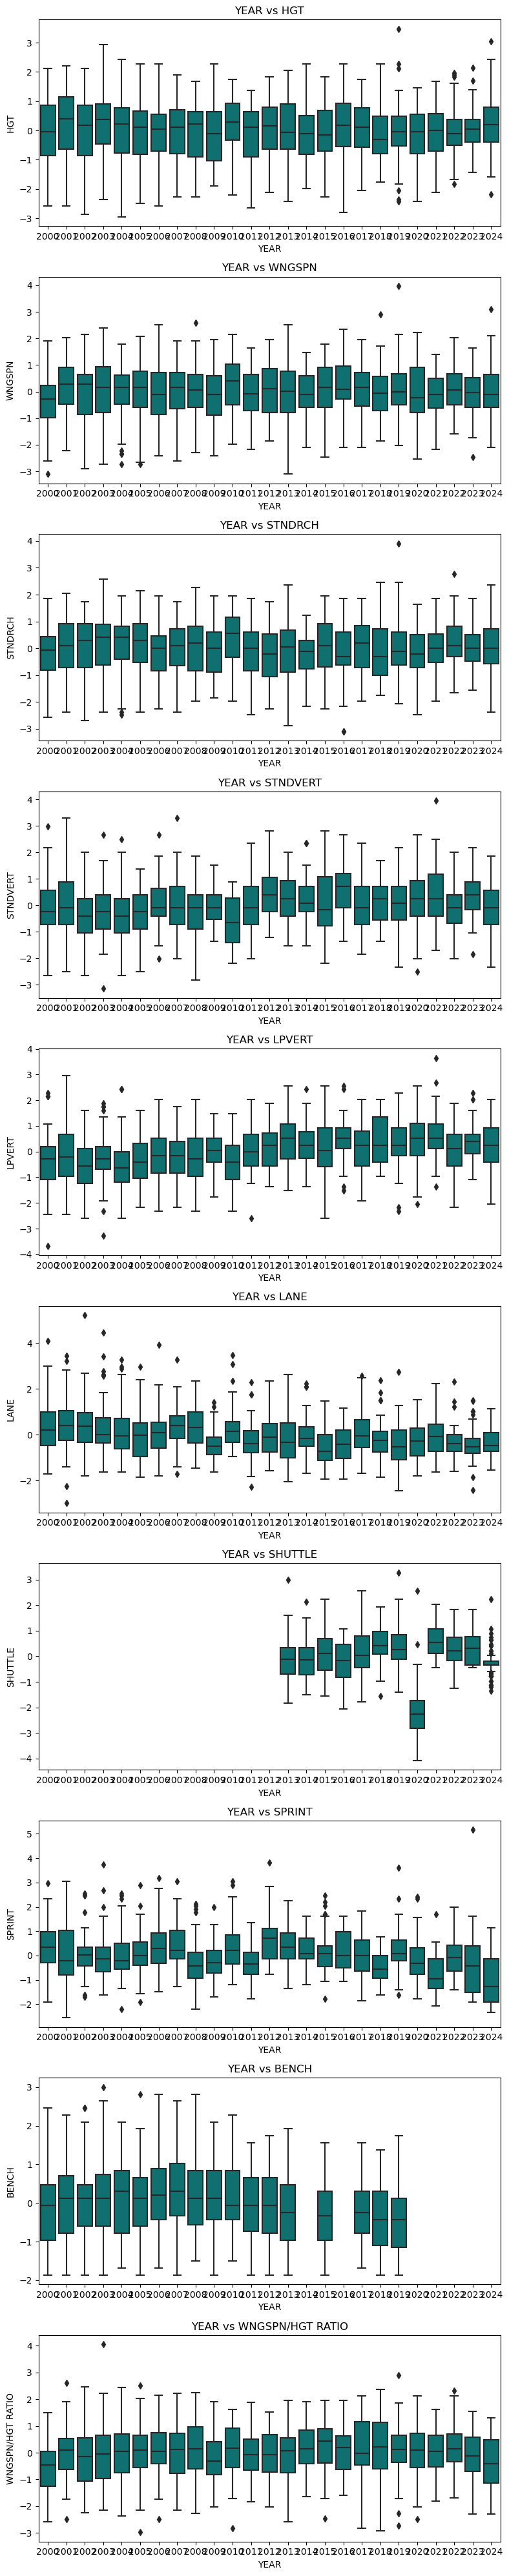

In [97]:
cols_to_graph = [col for col in df.columns if col not in ['YEAR', 'PLAYER', 'POS', 'WGT']]
num_plots = len(cols_to_graph)
fig, axes = plt.subplots(nrows = num_plots, figsize = (8, num_plots * 4))

for i, col in enumerate(cols_to_graph):
    sns.boxplot(x = df['YEAR'], y = df[col], ax=axes[i], color='teal')
    axes[i].set_title(f'YEAR vs {col}')
    axes[i].set_xlabel('YEAR')
    axes[i].set_ylabel(f'{col}')

plt.tight_layout()
plt.show()

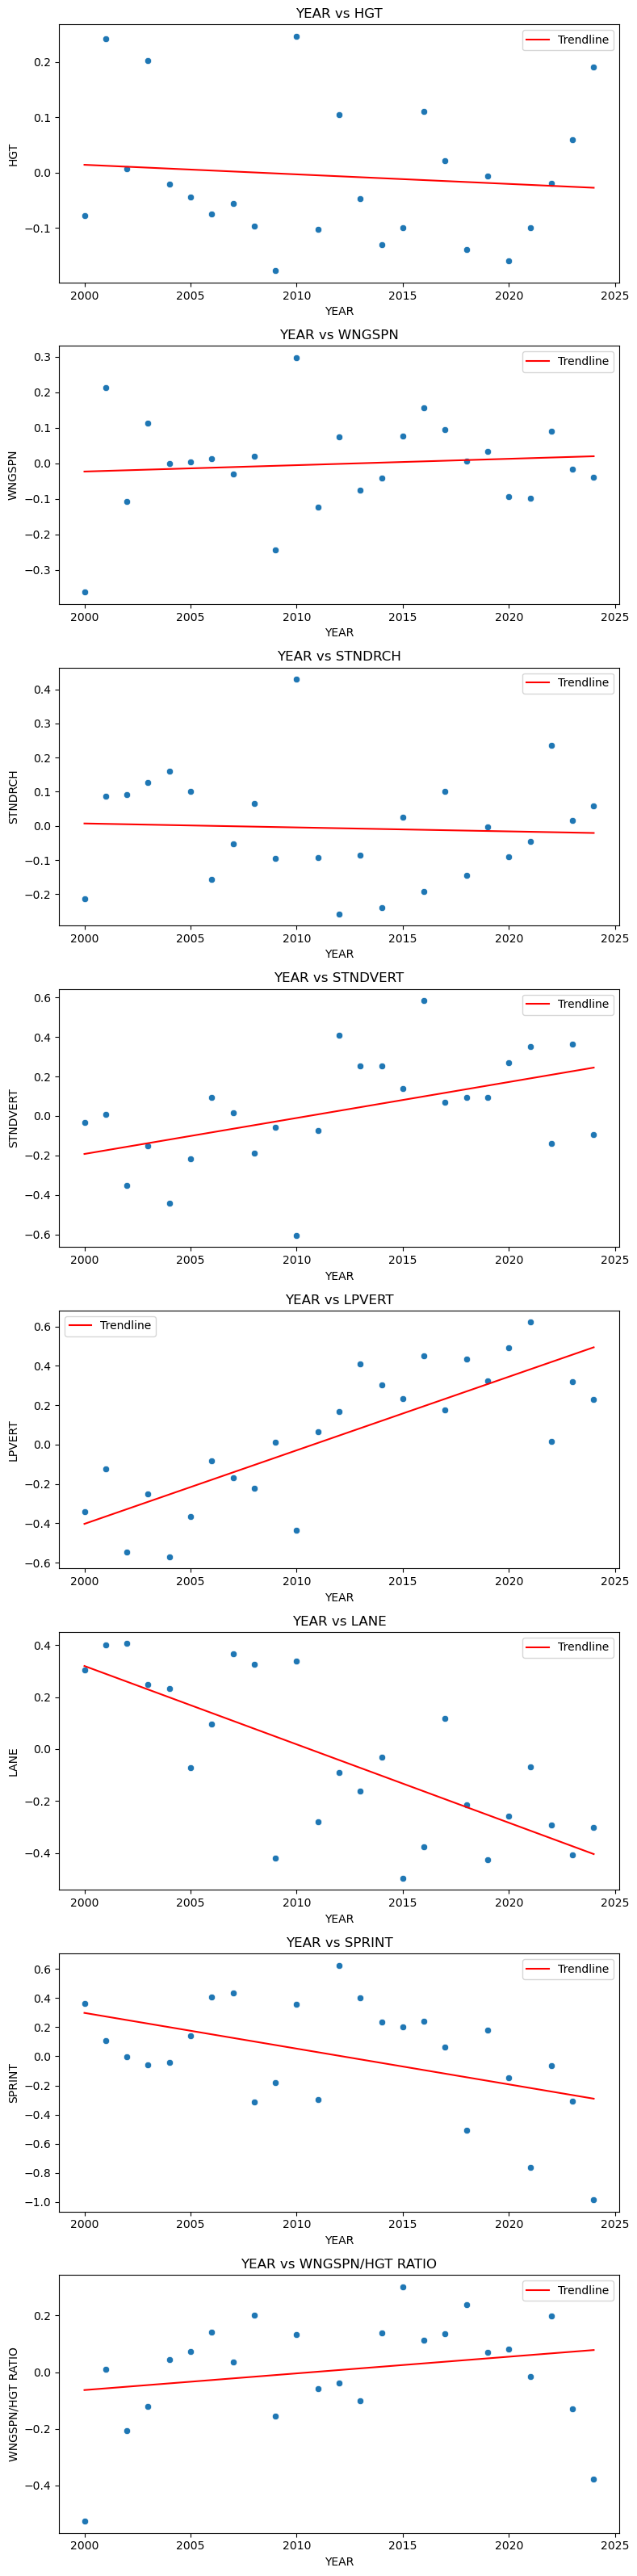

In [98]:
df_avgs = df.groupby('YEAR').mean(numeric_only=True)

cols_to_graph = [col for col in df.columns if col not in ['YEAR', 'PLAYER', 'POS', 'WGT', 'BENCH', 'SHUTTLE']]
num_plots = len(cols_to_graph)
fig, axes = plt.subplots(nrows = num_plots, figsize = (8, num_plots * 4))

slopes = {}

for i, col in enumerate(cols_to_graph):
    sns.scatterplot(x = df_avgs.index, y = df_avgs[col], ax=axes[i])
    
    x_values = df_avgs.index.astype(float)
    y_values = df_avgs[col].values
    
    slope, intercept = np.polyfit(x_values, y_values, 1)
    slopes[col] = slope
    
    trendline = slope * x_values + intercept
    sns.lineplot(x=x_values, y=trendline, ax=axes[i], color='red', label="Trendline")
    
    axes[i].set_title(f'YEAR vs {col}')
    axes[i].set_xlabel('YEAR')
    axes[i].set_ylabel(f'{col}')

plt.tight_layout()
plt.show()

In [114]:
print('All Players:')
print('')
for col, slope in slopes.items():
    if col in ['STNDVERT', 'LPVERT', 'LANE', 'SPRINT']:
        print(f'{col} has slope of: {slope.round(3)}')

All Players:

STNDVERT has slope of: 0.018
LPVERT has slope of: 0.037
LANE has slope of: -0.03
SPRINT has slope of: -0.025


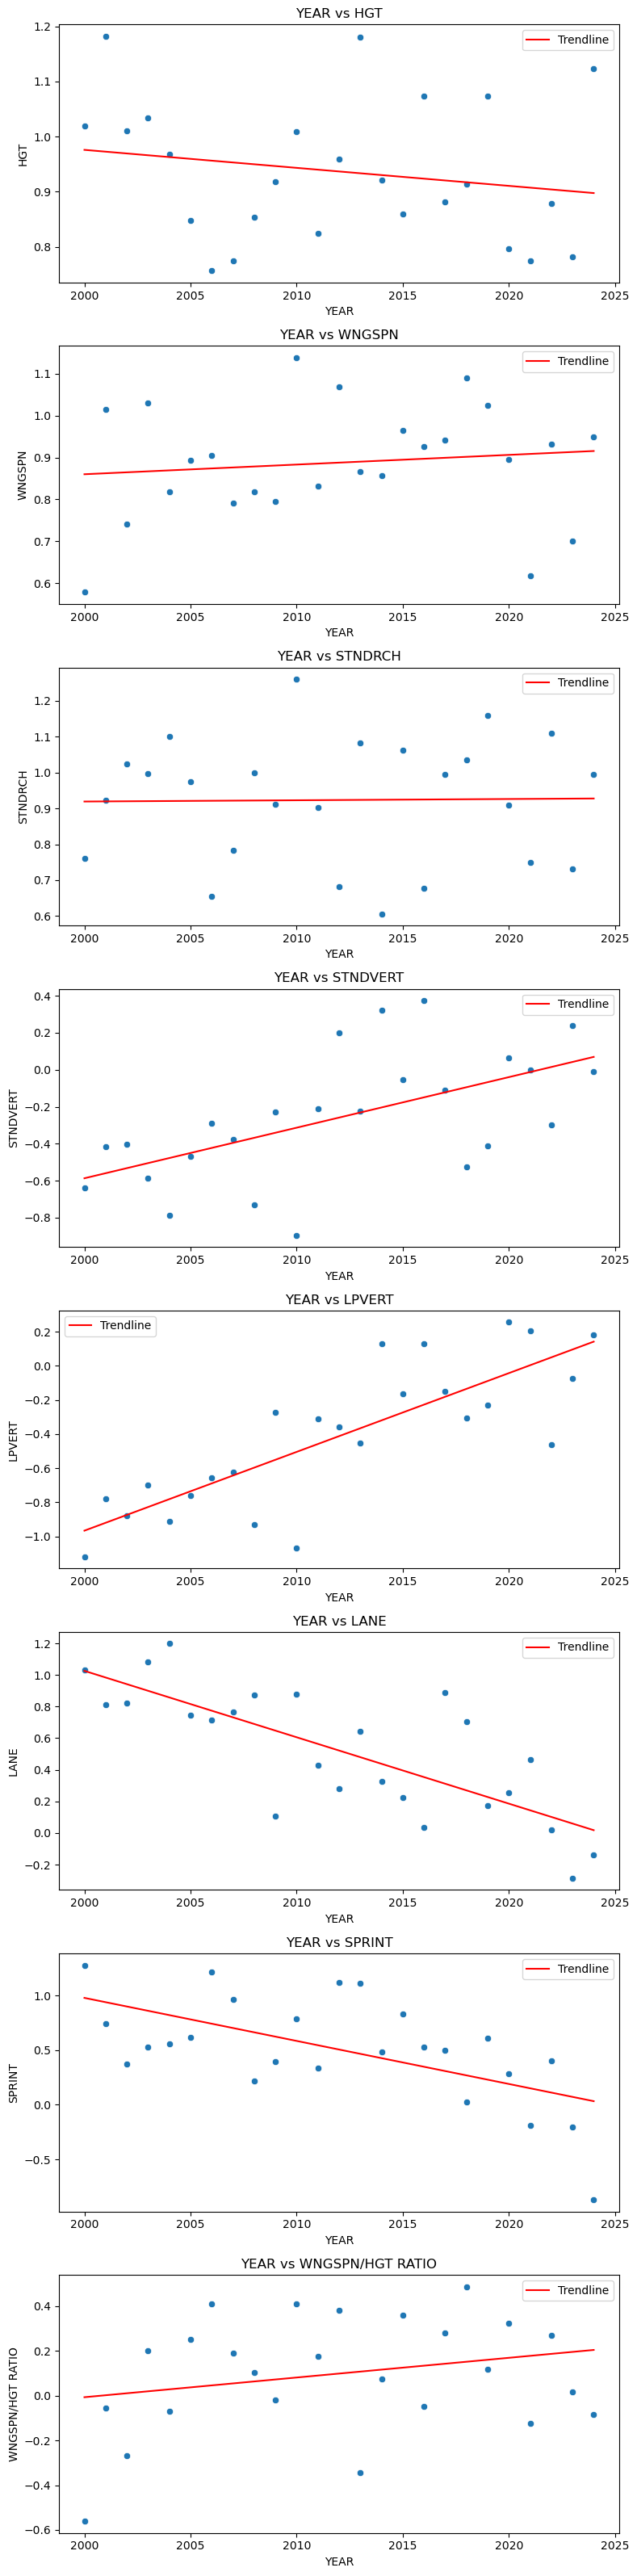

In [102]:
df_tall_pos_avgs = df.loc[df['POS'].isin(['C', 'PF', 'PF-C', 'C-PF'])].groupby('YEAR').mean(numeric_only=True)

cols_to_graph = [col for col in df.columns if col not in ['YEAR', 'PLAYER', 'POS', 'WGT', 'BENCH', 'SHUTTLE']]
num_plots = len(cols_to_graph)
fig, axes = plt.subplots(nrows = num_plots, figsize = (8, num_plots * 4))

tall_pos_slopes = {}

for i, col in enumerate(cols_to_graph):
    sns.scatterplot(x = df_tall_pos_avgs.index, y = df_tall_pos_avgs[col], ax=axes[i])
    
    x_values = df_tall_pos_avgs.index.astype(float)
    y_values = df_tall_pos_avgs[col].values
    
    slope, intercept = np.polyfit(x_values, y_values, 1)
    tall_pos_slopes[col] = slope
    
    trendline = slope * x_values + intercept
    sns.lineplot(x=x_values, y=trendline, ax=axes[i], color='red', label="Trendline")
    
    axes[i].set_title(f'YEAR vs {col}')
    axes[i].set_xlabel('YEAR')
    axes[i].set_ylabel(f'{col}')

plt.tight_layout()
plt.show()

In [115]:
print('Centers and Power Forwards:')
print('')
for col, slope in tall_pos_slopes.items():
    if col in ['STNDVERT', 'LPVERT', 'LANE', 'SPRINT']:
        print(f'{col} has slope of: {slope.round(3)}')

Centers and Power Forwards:

STNDVERT has slope of: 0.027
LPVERT has slope of: 0.046
LANE has slope of: -0.042
SPRINT has slope of: -0.039


In [105]:
tall_athleticism = (tall_pos_slopes['STNDVERT'] + tall_pos_slopes['LPVERT'] - tall_pos_slopes['LANE'] - tall_pos_slopes['SPRINT']) / 4

In [106]:
tall_athleticism

0.03872695684701948

In [107]:
regular_athleticism = (slopes['STNDVERT'] + slopes['LPVERT'] - slopes['LANE'] - slopes['SPRINT']) / 4

In [108]:
regular_athleticism

0.027591552235034875

In [109]:
def calculate_athleticism(data):
    cols = ['STNDVERT', 'LPVERT', 'LANE', 'SPRINT']
    slopes_vals = {}
    for col in cols:
        x_values = data.index.astype(float)
        y_values = data[col].values
        slope_val, intercept = np.polyfit(x_values, y_values, 1)
        slopes_vals[col] = slope_val
        
    return (slopes_vals['STNDVERT'] + slopes_vals['LPVERT'] - slopes_vals['LANE'] - slopes_vals['SPRINT']) / 4

def calculate_wngspn_hgt_ratio(data):
    x_values = data.index.astype(float)
    y_values = data['WNGSPN/HGT RATIO'].values
    slope_val, intercept = np.polyfit(x_values, y_values, 1)
    return slope_val

def permutation_test(df, num_reps=1000):
    df_tall_pos_avgs = df.loc[df['POS'].isin(['C', 'PF', 'PF-C', 'C-PF'])].groupby('YEAR').mean(numeric_only=True)
    tall_athleticism = calculate_athleticism(df_tall_pos_avgs)
    
    observed_val = tall_athleticism
    
    athleticism_values = []
    
    for _ in np.arange(num_reps):
        shuffled = np.random.permutation(df['POS'])
        shuffled_data = df.assign(shuffled_pos=shuffled)
        
        shuffled_df_tall_pos_avgs = shuffled_data.loc[shuffled_data['shuffled_pos'].isin(['C', 'PF', 'PF-C', 'C-PF'])].groupby('YEAR').mean(numeric_only=True)
        shuffled_athleticism = calculate_athleticism(shuffled_df_tall_pos_avgs)
        
        athleticism_values.append(shuffled_athleticism)
    
    p_value = np.count_nonzero(athleticism_values >= observed_val) / num_reps
    return observed_val, athleticism_values, p_value

In [110]:
observed_tall_athleticism, athleticism_perm_values, p_value = permutation_test(df)

In [111]:
observed_tall_athleticism

0.03872695684701948

In [112]:
p_value

0.002

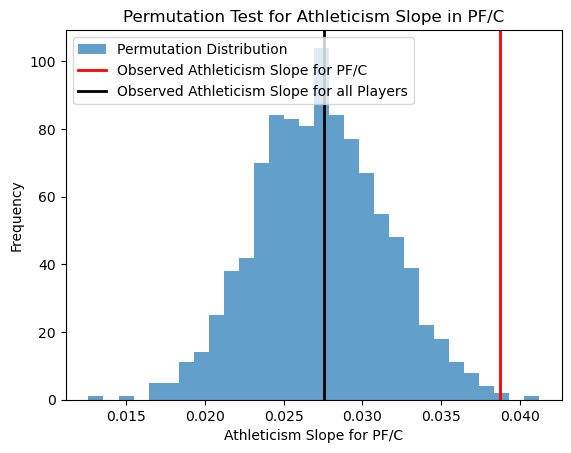

In [113]:
# Plot the permutation distribution
plt.hist(athleticism_perm_values, bins=30, alpha=0.7, label='Permutation Distribution')
plt.axvline(observed_tall_athleticism, color='red', linewidth=2, label='Observed Athleticism Slope for PF/C')
plt.axvline(regular_athleticism, color='black', linewidth=2, label='Observed Athleticism Slope for all Players')
plt.title(f'Permutation Test for Athleticism Slope in PF/C')
plt.xlabel('Athleticism Slope for PF/C')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Creating stat vs MP graphs

In [51]:
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Important DataFrames\NBA_draft_combine.csv").drop(columns = ['BF', 'BMI', 'HANDL', 'HANDW', 'BAR', 'PAN', 'PBHGT', 'PDHGT'])

In [52]:
df['LANE'] = -df['LANE']
df['SHUTTLE'] = -df['SHUTTLE']
df = df[df['YEAR'] > 2015]

In [53]:
df

,YEAR,PLAYER,POS,HGT,WGT,WNGSPN,STNDRCH,STNDVERT,LPVERT,LANE,SHUTTLE,SPRINT,BENCH
0,2024,"Ajayi, Michael",SF,77.80,227.8,84.80,106.5,27.0,34.5,-12.00,-3.17,3.21,NaN
1,2024,"Ajinca, Melvin",SF,79.30,213.8,79.50,106.5,26.5,31.0,-12.00,-3.00,3.38,NaN
2,2024,"Alexander, Trey",SG,75.30,187.0,82.50,101.5,27.0,32.0,-11.00,-3.00,3.00,NaN
3,2024,"Almansa, Izan",C,81.30,219.6,85.00,110.0,28.0,35.0,-11.00,-3.00,3.00,NaN
4,2024,"Beekman, Reece",PG,73.30,196.4,78.50,100.0,30.0,37.0,-11.00,-3.00,3.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,2016,"Valentine, Denzel",SG-SF,76.00,210.4,82.75,102.0,27.0,32.0,-10.51,-3.22,3.46,NaN
534,2016,"Whitehead, Isaiah",PG-SG,75.25,210.0,80.75,100.0,27.5,35.5,-11.65,-3.21,3.34,NaN
535,2016,"Williams, Troy",SF,77.75,217.8,80.25,102.0,30.0,36.0,-10.72,-3.08,3.35,NaN
536,2016,"Wiltjer, Kyle",PF,80.75,242.8,84.25,102.5,28.5,35.5,-11.35,-3.04,3.48,NaN


In [54]:
important_df = df.drop(columns = [col for col in df.columns if col not in ['PLAYER', 'POS', 'STNDVERT', 'LPVERT', 'LANE', 'SPRINT']])

In [55]:
cols_to_standardize = [col for col in df.columns if col in ['STNDVERT', 'LPVERT', 'LANE', 'SPRINT']]
important_df[cols_to_standardize] = important_df.groupby('POS')[cols_to_standardize].transform(lambda x: (x - x.mean()) / x.std())

In [56]:
important_df

,PLAYER,POS,STNDVERT,LPVERT,LANE,SPRINT
0,"Ajayi, Michael",SF,-0.977675,-0.423990,-1.563683,0.052478
1,"Ajinca, Melvin",SF,-1.148659,-1.500727,-1.563683,1.273279
2,"Alexander, Trey",SG,-1.058024,-1.496447,0.126796,-1.314536
3,"Almansa, Izan",C,-0.203150,0.419592,1.459305,-1.632598
4,"Beekman, Reece",PG,0.022826,0.116178,0.051079,-1.575167
...,...,...,...,...,...,...
533,"Valentine, Denzel",SG-SF,-1.015647,-1.230386,1.989717,1.525178
534,"Whitehead, Isaiah",PG-SG,-0.991440,-0.514776,-0.687111,0.940125
535,"Williams, Troy",SF,0.048226,0.037469,1.064568,1.057843
536,"Wiltjer, Kyle",PF,-0.278869,0.116448,0.027352,1.654550


In [57]:
important_df['PLAYER'] = important_df['PLAYER'].apply(lambda x: x.split(', ')[1] + ' ' + x.split(', ')[0] if ', ' in x else x)

In [58]:
important_df

,PLAYER,POS,STNDVERT,LPVERT,LANE,SPRINT
0,Michael Ajayi,SF,-0.977675,-0.423990,-1.563683,0.052478
1,Melvin Ajinca,SF,-1.148659,-1.500727,-1.563683,1.273279
2,Trey Alexander,SG,-1.058024,-1.496447,0.126796,-1.314536
3,Izan Almansa,C,-0.203150,0.419592,1.459305,-1.632598
4,Reece Beekman,PG,0.022826,0.116178,0.051079,-1.575167
...,...,...,...,...,...,...
533,Denzel Valentine,SG-SF,-1.015647,-1.230386,1.989717,1.525178
534,Isaiah Whitehead,PG-SG,-0.991440,-0.514776,-0.687111,0.940125
535,Troy Williams,SF,0.048226,0.037469,1.064568,1.057843
536,Kyle Wiltjer,PF,-0.278869,0.116448,0.027352,1.654550


In [69]:
mins_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\df_with_all_positions_and_teams(2001-2024).csv")
mins_df = mins_df.drop(columns=[col for col in mins_df if col not in ['Player', 'MP']])
mins_df = mins_df.groupby('Player').sum().reset_index()
#mins_df = mins_df[mins_df['MP'] > 100]
standardized_with_mins = pd.merge(important_df, mins_df, left_on='PLAYER', right_on='Player').drop(columns=['Player']).dropna()

In [70]:
standardized_with_mins

,PLAYER,POS,STNDVERT,LPVERT,LANE,SPRINT,MP
0,Amari Bailey,SG,-0.580841,-0.580045,0.126796,0.050031,65.0
1,Emoni Bates,SF,-0.977675,-0.885449,-1.563683,-1.455570,133.0
2,Anthony Black,PG,0.698467,0.709084,0.051079,-1.575167,1164.0
3,Kobe Brown,PF,-0.119771,-0.999658,0.731502,-1.929749,394.0
4,Kobe Bufkin,SG,-0.421780,-0.274577,-2.680374,-1.314536,196.0
...,...,...,...,...,...,...,...
357,Denzel Valentine,SG-SF,-1.015647,-1.230386,1.989717,1.525178,4817.0
358,Isaiah Whitehead,PG-SG,-0.991440,-0.514776,-0.687111,0.940125,1823.0
359,Troy Williams,SF,0.048226,0.037469,1.064568,1.057843,1176.0
360,Kyle Wiltjer,PF,-0.278869,0.116448,0.027352,1.654550,44.0


In [71]:
pf_c_df = standardized_with_mins[standardized_with_mins['POS'].isin(['PF', 'C', 'PF-C', 'C-PF'])]

In [72]:
pf_c_df

,PLAYER,POS,STNDVERT,LPVERT,LANE,SPRINT,MP
3,Kobe Brown,PF,-0.119771,-0.999658,0.731502,-1.929749,394.0
5,Toumani Camara,PF,-0.119771,-0.680771,0.731502,-1.929749,1739.0
12,Taylor Hendricks,PF,1.153018,0.275891,0.188301,-1.929749,856.0
15,Trayce Jackson-Davis,C,1.211187,0.944081,-0.117160,-1.632598,1130.0
23,Leonard Miller,PF,0.834821,0.754223,0.731502,0.534457,52.0
...,...,...,...,...,...,...,...
353,Pascal Siakam,PF,0.357525,0.435335,0.228538,1.131840,17089.0
354,Diamond Stone,C,-0.486018,-1.022754,-0.550688,1.131961,24.0
356,Jarrod Uthoff,PF,-0.119771,-0.202440,-0.314663,1.803896,168.0
360,Kyle Wiltjer,PF,-0.278869,0.116448,0.027352,1.654550,44.0


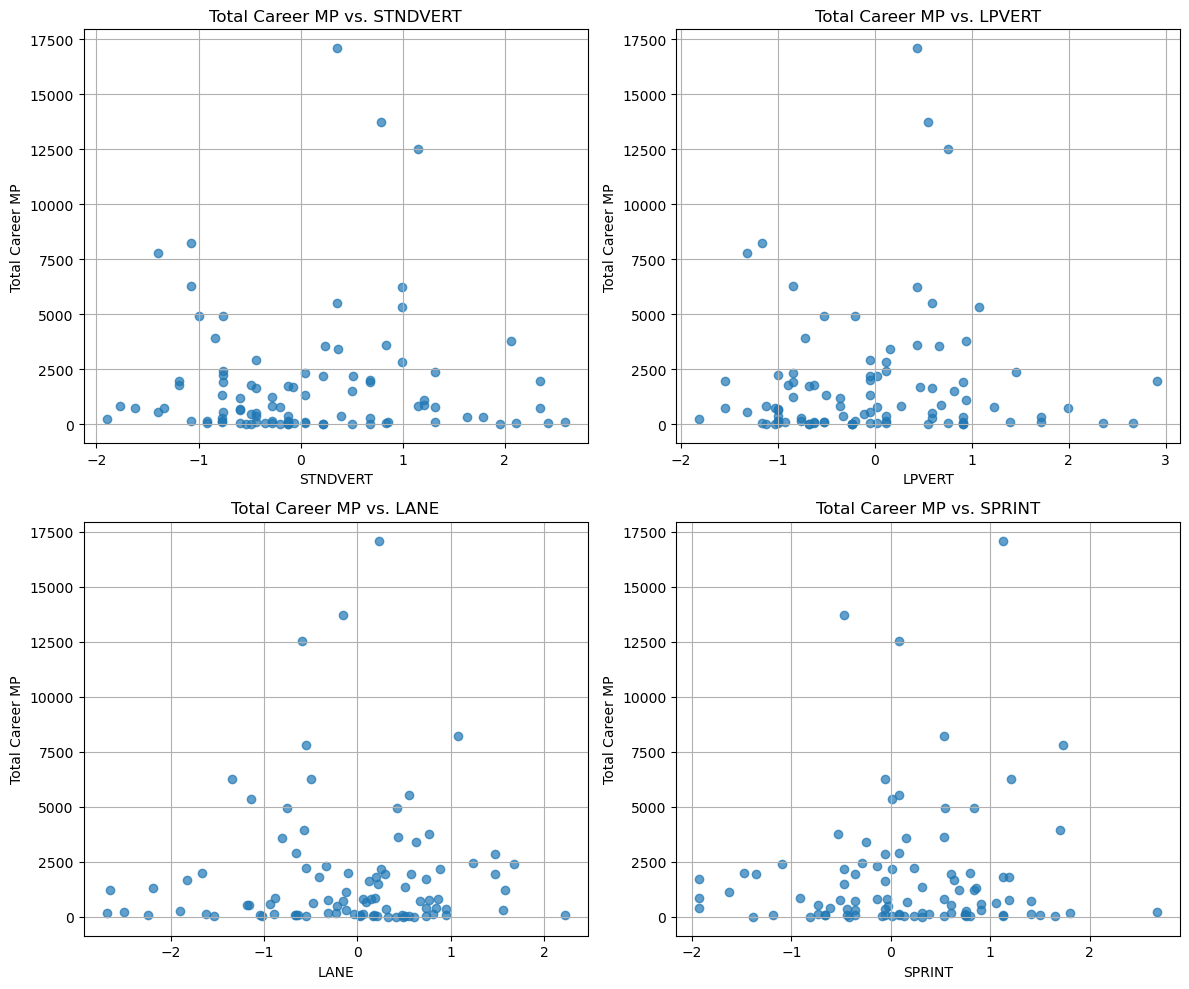

In [73]:
metrics = ['STNDVERT', 'LPVERT', 'LANE', 'SPRINT']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, metric in zip(axes.flatten(), metrics):
    ax.scatter(pf_c_df[metric], pf_c_df['MP'], alpha=0.7)
    ax.set_xlabel(metric)
    ax.set_ylabel('Total Career MP')
    ax.set_title(f'Total Career MP vs. {metric}')
    ax.grid(True)

plt.tight_layout()
plt.show()